In [1]:
import os
from ecm.model import ECMmodel
import logging
import inspect
from sbtab import SBtab
import matplotlib.pyplot as plt
%matplotlib inline

## Loading model and validation data from SBtab file

In [3]:
SCRIPT_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
DATA_DIR = os.path.join(SCRIPT_DIR, 'data')
RESULT_DIR = os.path.join(SCRIPT_DIR, 'res')

exp_name = 'ecoli_ccm_aerobic_ProteinComposition_haverkorn_ECM'
modeldata_fname = os.path.join(DATA_DIR, '%s_Model.tsv' % exp_name)
validationdata_fname = os.path.join(DATA_DIR, '%s_ValidationData.tsv' % exp_name)

#%%
logging.info('Reading SBtab files')
modeldata_sbtabs = SBtab.read_csv(modeldata_fname, "model")
validationdata_sbtabs = SBtab.read_csv(validationdata_fname, "validation")

#%%
logging.info('Creating an ECM model using the data')
ecf_params = {'regularization': 'volume'}

model = ECMmodel.FromSBtab(modeldata_sbtabs, ecf_params=ecf_params)
model.AddValidationData(validationdata_sbtabs)

In [4]:
modeldata_sbtabs.get_sbtab_by_id('Reaction').to_data_frame().head()

ID                                    ReactionFormula  \
0  PTS_RPTSsy  D_Glucose + Phosphoenolpyruvate <=> Pyruvate +...   
1  PGI_R02740   D_Glucose_6_phosphate <=> D_Fructose_6_phosphate   
2  PFK_R04779  ATP + D_Fructose_6_phosphate <=> ADP + D_Fruct...   
3  ALD_R01070  D_Fructose_1_6_bisphosphate <=> Glycerone_phos...   
4  TIM_R01015  Glycerone_phosphate <=> D_Glyceraldehyde_3_pho...   

  Identifiers:kegg.reaction IsReversible Gene NameForPlots  
0                    RPTSsy         True  PTS          pts  
1                    R02740         True  PGI          pgi  
2                    R04779         True  PFK          pfk  
3                    R01070         True  FBA          fba  
4                    R01015         True  TPI          tim

In [5]:
modeldata_sbtabs.get_sbtab_by_id('Compound').to_data_frame().head()

ID                   Name Identifiers:kegg.compound  \
0              _S__Malate             (S)-Malate                    C00149   
1              Acetyl_CoA             Acetyl-CoA                    C00024   
2                Fumarate               Fumarate                    C00122   
3           cis_Aconitate          cis-Aconitate                    C00417   
4  _6_Phospho_D_gluconate  6-Phospho-D-gluconate                    C00345   

  IsConstant NameForPlots  
0      False          mal  
1      False       acecoa  
2      False          fum  
3      False          aco  
4      False          6pg

In [6]:
modeldata_sbtabs.get_sbtab_by_id('Parameter').to_data_frame().head()

QuantityType    Reaction Compound      Value           Unit  \
0  equilibrium constant  PTS_RPTSsy            52122111  dimensionless   
1  equilibrium constant  PGI_R02740           0.3654504  dimensionless   
2  equilibrium constant  PFK_R04779           1696.7518  dimensionless   
3  equilibrium constant  ALD_R01070           0.1905667  dimensionless   
4  equilibrium constant  TIM_R01015           0.1086024  dimensionless   

  Reaction:Identifiers:kegg.reaction Compound:Identifiers:kegg.compound  \
0                             RPTSsy                                      
1                             R02740                                      
2                             R04779                                      
3                             R01070                                      
4                             R01015                                      

       ID  
0  kEQ_R1  
1  kEQ_R2  
2  kEQ_R3  
3  kEQ_R4  
4  kEQ_R5

In [7]:
modeldata_sbtabs.get_sbtab_by_id('RelativeFlux').to_data_frame().head()

QuantityType    Reaction Reaction:Identifiers:kegg.reaction    Value
0         flux  PTS_RPTSsy                             RPTSsy   0.5691
1         flux  PGI_R02740                             R02740    0.385
2         flux  PFK_R04779                             R04779   0.4417
3         flux  ALD_R01070                             R01070  0.44702
4         flux  TIM_R01015                             R01015   0.4445

In [8]:
modeldata_sbtabs.get_sbtab_by_id('ConcentrationConstraint').to_data_frame().head()

QuantityType                Compound Compound:Identifiers:kegg.compound  \
0  concentration              _S__Malate                             C00149   
1  concentration              Acetyl_CoA                             C00024   
2  concentration                Fumarate                             C00122   
3  concentration           cis_Aconitate                             C00417   
4  concentration  _6_Phospho_D_gluconate                             C00345   

  Concentration:Min Concentration:Max  
0             0.001                10  
1             0.001                10  
2             0.001                10  
3             0.001                10  
4             0.001                10

In [9]:
print('Solving MDF problem')
lnC_MDF = model.MDF()
print('Solving ECM problem')
lnC_ECM = model.ECM(n_iter=5)
res_sbtab = model.ToSBtab(lnC_ECM)

Solving MDF problem
Solving ECM problem


In [10]:
res_sbtab.get_sbtab_by_id('Predicted concentrations').to_data_frame().head()

QuantityType Compound Compound:Identifiers:kegg.compound  \
0  concentration      atp                             C00002   
1  concentration      nad                             C00003   
2  concentration     nadh                             C00004   
3  concentration    nadph                             C00005   
4  concentration     nadp                             C00006   

                      ecm  
0    0.003449139499999999  
1   0.0010000000000000002  
2  2.7415130000000013e-05  
3  0.00011389157000000001  
4  0.00010000000000000009

In [11]:
res_sbtab.get_sbtab_by_id('Predicted enzyme levels').to_data_frame().head()

QuantityType Reaction Reaction:Identifiers:kegg.reaction  \
0  concentration of enzyme      pts                         PTS_RPTSsy   
1  concentration of enzyme      pgi                         PGI_R02740   
2  concentration of enzyme      pfk                         PFK_R04779   
3  concentration of enzyme      fba                         ALD_R01070   
4  concentration of enzyme      tim                         TIM_R01015   

                      ecm  
0  1.5942524899394075e-05  
1  2.1297701836288318e-05  
2   8.266215078892349e-06  
3  5.7987819565352086e-05  
4  1.0320161756503313e-05

In [12]:
fig1 = plt.figure(figsize=(14, 5))
ax_MDF = fig1.add_subplot(1, 2, 1)
model.PlotEnzymeDemandBreakdown(lnC_MDF, ax_MDF, plot_measured=True)
ax_ECM = fig1.add_subplot(1, 2, 2, sharey=ax_MDF)
model.PlotEnzymeDemandBreakdown(lnC_ECM, ax_ECM, plot_measured=True)

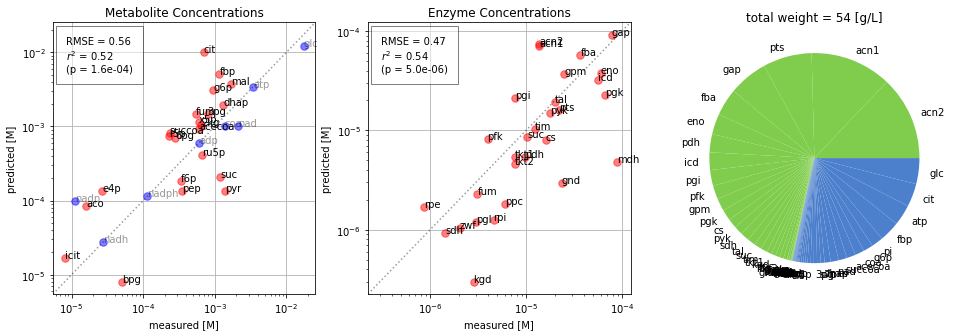

In [13]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(1, 3, 1, xscale='log', yscale='log')
ax.set_title('Metabolite Concentrations')
model.ValidateMetaboliteConcentrations(lnC_ECM, ax)

ax = fig.add_subplot(1, 3, 2, xscale='log', yscale='log')
ax.set_title('Enzyme Concentrations')
model.ValidateEnzymeConcentrations(lnC_ECM, ax)

ax = fig.add_subplot(1, 3, 3)
vols, labels, colors = model._GetVolumeDataForPlotting(lnC_ECM)
ax.pie(vols, labels=labels, colors=colors)
ax.set_title('total weight = %.2g [g/L]' % sum(vols));